In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from IPython.core.display_functions import display
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from pyclustering.cluster.clarans import clarans
from sklearn.decomposition import PCA
import warnings
import time

warnings.filterwarnings('ignore')

# # Adjusting for Data Frame Output
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

In [19]:
# Categorical feature need to change numeric
# Encoder
def object_encoder(dataframe, encoder, target_feature):
    if encoder == "LabelEncoder" or encoder == "LabelEncoder()":
        encoder = LabelEncoder()
        dataframe[target_feature] = encoder.fit_transform(dataframe[target_feature])
    elif encoder == "OrdinalEncoder" or encoder == "OrdinalEncoder()":
        encoder = LabelEncoder()
        dataframe[target_feature] = encoder.fit_transform(dataframe[target_feature])
    elif encoder is None:
        return dataframe
    else:
        return None

    return dataframe

In [20]:
# Scaling
def data_scaling(dataframe, scaling):
    if scaling == "StandardScaler" or scaling == "StandardScaler()":
        scaling = StandardScaler()
    elif scaling == "MinMaxScaler" or scaling == "MinMaxScaler()":
        scaling = MinMaxScaler()
    elif scaling == "MaxAbsScaler" or scaling == "MaxAbsScaler()":
        scaling = MaxAbsScaler()
    elif scaling == "RobustScaler" or scaling == "RobustScaler()":
        scaling = RobustScaler()
    elif scaling == "Normalizer" or scaling == "Normalizer()":
        scaling = Normalizer()
    elif scaling is None:
        return dataframe
    else:
        return None

    dataframe = pd.DataFrame(scaling.fit_transform(dataframe), columns=dataframe.columns)
    return dataframe

In [21]:
# K-means
def model_kmeans(dataset, clusters_list=None, n_init_list=None):
    start = time.process_time()
    time.sleep(1)

    # Parameters
    if clusters_list is None:
        clusters_list = [2, 4, 6, 8]  # count of clustering
    if n_init_list is None:
        n_init_list = [10, 20, 30]
    algorithm_list = ["auto", "full", "elkan"]  # algorithm list

    pca = PCA(n_components=2)  # Reduce feature for plotting
    dataset = pd.DataFrame(pca.fit_transform(dataset))

    row_count = len(n_init_list) * len(algorithm_list)
    col_count = len(clusters_list)
    fig, axes = plt.subplots(row_count, col_count, constrained_layout=True, figsize=(15, 20))
    fig.suptitle("K-means")

    for num_k, k in enumerate(clusters_list):
        for num_init, init in enumerate(n_init_list):
            for num_algo, algo in enumerate(algorithm_list):
                kmeans = KMeans(n_clusters=k, n_init=init, algorithm=algo, random_state=42).fit(dataset)
                labels = kmeans.predict(dataset)
                x_row = num_init * len(algorithm_list) + num_algo
                y_col = num_k
                axes[x_row, y_col].set_title(
                    "[cluster = " + str(k) + ", n_init = " + str(init)
                    + ", algorithm = " + str(algo) + "]", fontdict={'fontsize': 11})
                axes[x_row, y_col].scatter(x=dataset.iloc[:, 0], y=dataset.iloc[:, 1],
                                           c=labels)

    print("K-mean Clustering running time: ", time.process_time() - start, "sec")
    return plt

In [22]:
# EM(GMM)
def model_gaussian(dataset, clusters_list=None):
    start = time.process_time()
    time.sleep(1)

    # Parameters
    if clusters_list is None:
        clusters_list = [2, 4, 6, 8]
    type_list = ['full', 'tied', 'diag', 'spherical']
    param_list = ['kmeans', 'random']

    pca = PCA(n_components=2)  # Reduce feature for plotting
    dataset = pd.DataFrame(pca.fit_transform(dataset))

    row_count = len(type_list) * len(param_list)
    col_count = len(clusters_list)
    fig, axes = plt.subplots(row_count, col_count, constrained_layout=True, figsize=(15, 20))
    fig.suptitle("EM (GMM)")

    for num_k, k in enumerate(clusters_list):
        for num_type, types in enumerate(type_list):
            for num_par, par in enumerate(param_list):
                gmm = GaussianMixture(n_components=k, init_params=par, covariance_type=types)
                labels = gmm.fit_predict(dataset)
                x_row = num_type * len(param_list) + num_par
                y_col = num_k
                axes[x_row, y_col].set_title("[cluster = " + str(k) + ", params = " + str(par)
                                             + ", type = " + str(types) + "]", fontdict={'fontsize': 10})
                axes[x_row, y_col].scatter(x=dataset.iloc[:, 0], y=dataset.iloc[:, 1], c=labels)

    print("EM(GMM) Clustering running time: ", time.process_time() - start, "sec")
    return plt

In [33]:
def model_clarans(dataset, clusters_list=None):
    start = time.process_time()
    time.sleep(1)

    # Parameters
    if clusters_list is None:
        clusters_list = [2, 4, 6, 8]
    local_list = [2, 4]
    neighbor_list = [3, 4]

    dataset.reset_index()
    pca = PCA(n_components=2)  # Reduce feature for plotting
    dataset = pd.DataFrame(pca.fit_transform(dataset))
    row_count = len(local_list) * len(neighbor_list)
    col_count = len(clusters_list)
    fig, axes = plt.subplots(row_count, col_count, constrained_layout=True, figsize=(15, 20))
    fig.suptitle("CLARANS")

    tuple_data = dataset.values.tolist()
    for number_k, k in enumerate(clusters_list):
        for number_local, local in enumerate(local_list):
            for number_neigh, neigh in enumerate(neighbor_list):
                clarans_obj = clarans(tuple_data, number_clusters=k, numlocal=local, maxneighbor=neigh)
                clarans_obj.process()
                labels = clarans_obj.get_clusters()
                med = clarans_obj.get_medoids()
                x_row = number_local * len(neighbor_list) + number_neigh
                y_col = number_k
                for i in range(len(labels)):
                    for j in range(len(labels[i])):
                        tmp_index = labels[i][j]
                        dataset.loc[tmp_index, 'Cluster'] = i

                axes[x_row, y_col].set_title("[cluster = " + str(k) + ", numlocal = " + str(local_list)
                                             + ", maxneighbor = " + str(neighbor_list) + "]", fontdict={'fontsize': 9})
                axes[x_row, y_col].scatter(x=dataset.iloc[:, 0], y=dataset.iloc[:, 1], c=dataset.loc[:, 'Cluster'])

    print("CLARANS Clustering running time: ", time.process_time() - start, "sec")
    return plt

In [ ]:
def model_dbscan(dataset, clusters_list=None):
    start = time.process_time()
    time.sleep(1)

    # Parameters
    if clusters_list is None:
        clusters_list = [2, 4, 6, 8]

    pca = PCA(n_components=2)  # Reduce feature for plotting
    dataset = pd.DataFrame(pca.fit_transform(dataset))

    return plt

In [ ]:
def model_meansift(dataset, clusters_list=None):
    start = time.process_time()
    time.sleep(1)

    if clusters_list is None:
        clusters_list = [2, 4, 6, 8]

    pca = PCA(n_components=2)  # Reduce feature for plotting
    dataset = pd.DataFrame(pca.fit_transform(dataset))

    return plt

In [24]:
# read Dataset
df_origin = pd.read_csv('dataset/housing.csv')

In [25]:
# Check data information
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [26]:
df_origin.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [27]:
# Copy dataset
df = df_origin.copy()

# Drop null data
df.dropna(axis=0, inplace=True)

display(df)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [28]:
# testing
df = object_encoder(df, 'OrdinalEncoder', "ocean_proximity")
df = data_scaling(df, "StandardScaler")

x = df.drop(columns=["median_house_value"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-1.327314,1.051717,0.982163,-0.803813,-0.970325,-0.973320,-0.976833,2.345163,1.291351
1,-1.322323,1.042355,-0.606210,2.042130,1.348276,0.861339,1.670373,2.332632,1.291351
2,-1.332305,1.037674,1.855769,-0.535189,-0.825561,-0.819769,-0.843427,1.782939,1.291351
3,-1.337296,1.037674,1.855769,-0.623510,-0.718768,-0.765056,-0.733562,0.932970,1.291351
4,-1.337296,1.037674,1.855769,-0.461970,-0.611974,-0.758879,-0.628930,-0.013143,1.291351
...,...,...,...,...,...,...,...,...,...
20428,-0.758318,1.800677,-0.288535,-0.444580,-0.388895,-0.511787,-0.443207,-1.216727,-0.117001
20429,-0.818212,1.805358,-0.844466,-0.887557,-0.920488,-0.943315,-1.008223,-0.692044,-0.117001
20430,-0.823203,1.777272,-0.923885,-0.175042,-0.125472,-0.368826,-0.173778,-1.143171,-0.117001
20431,-0.873115,1.777272,-0.844466,-0.355344,-0.305834,-0.603564,-0.393506,-1.055136,-0.117001


<AxesSubplot: >

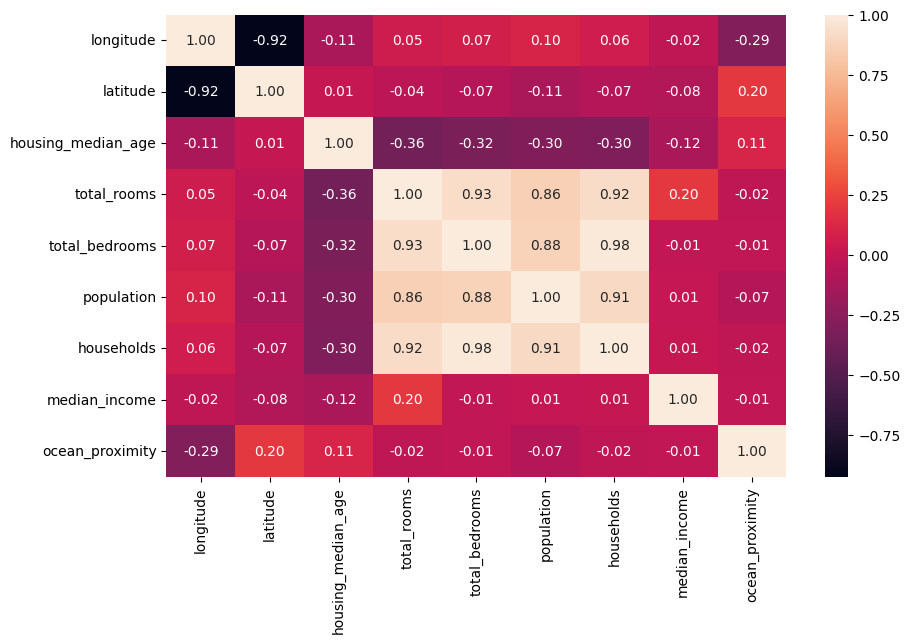

In [29]:
# Check the correlation of dataset between target and features
plt.figure(figsize=(10, 6))
sns.heatmap(x.corr(), annot=True, fmt='0.2f')

K-mean Clustering running time:  8.65625 sec


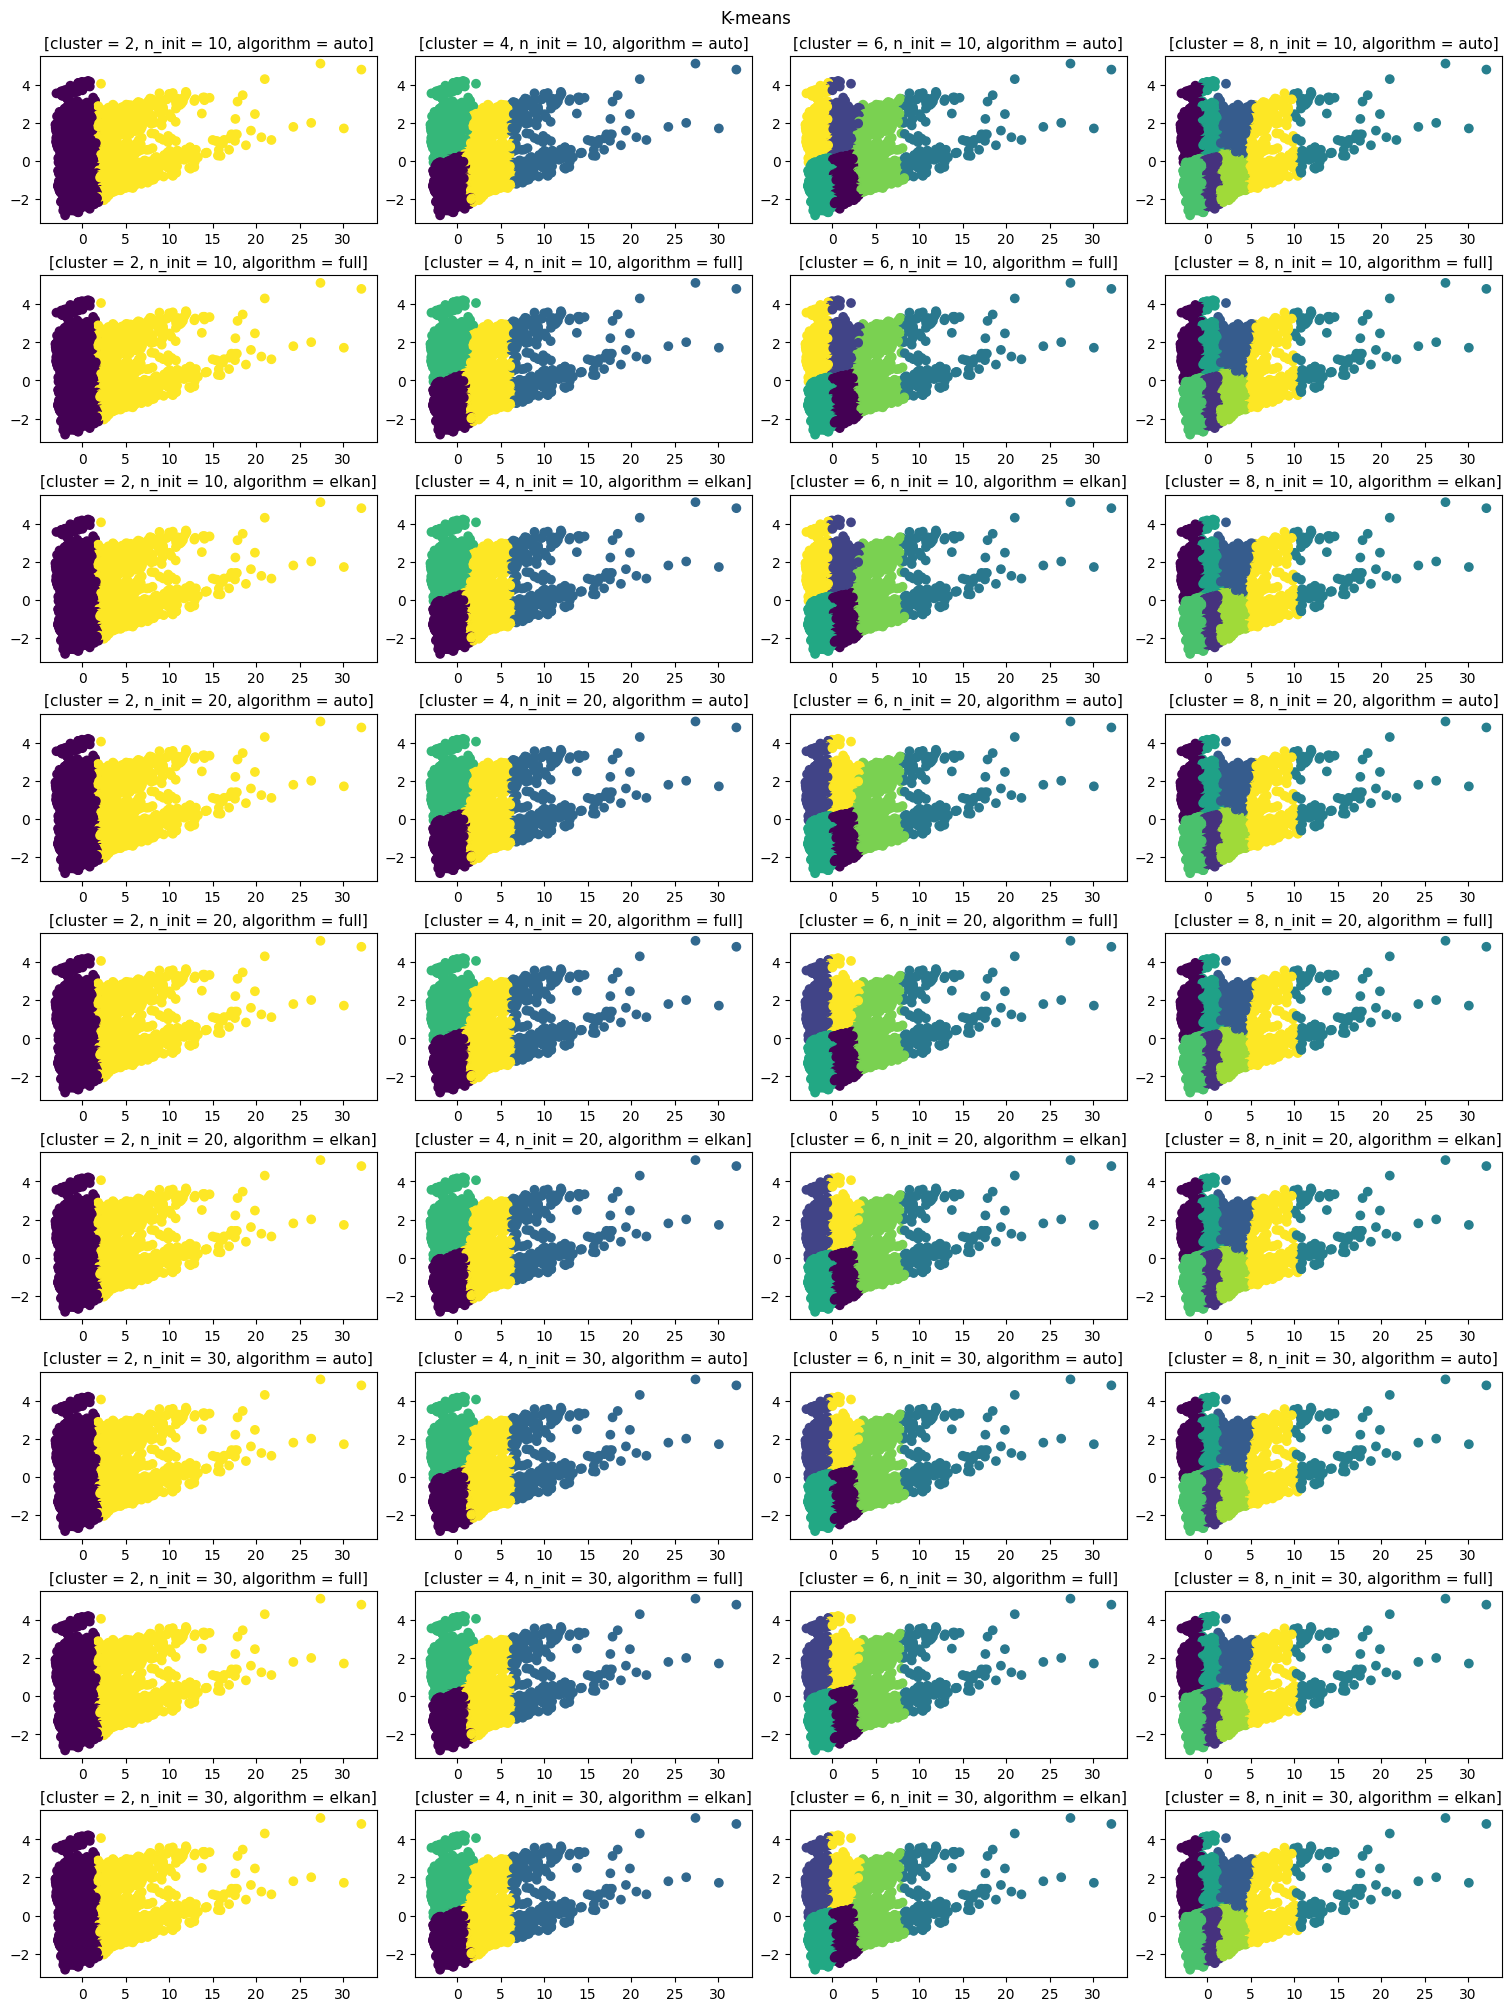

In [30]:
data = model_kmeans(x)
data.show()

EM(GMM) Clustering running time:  3.875 sec


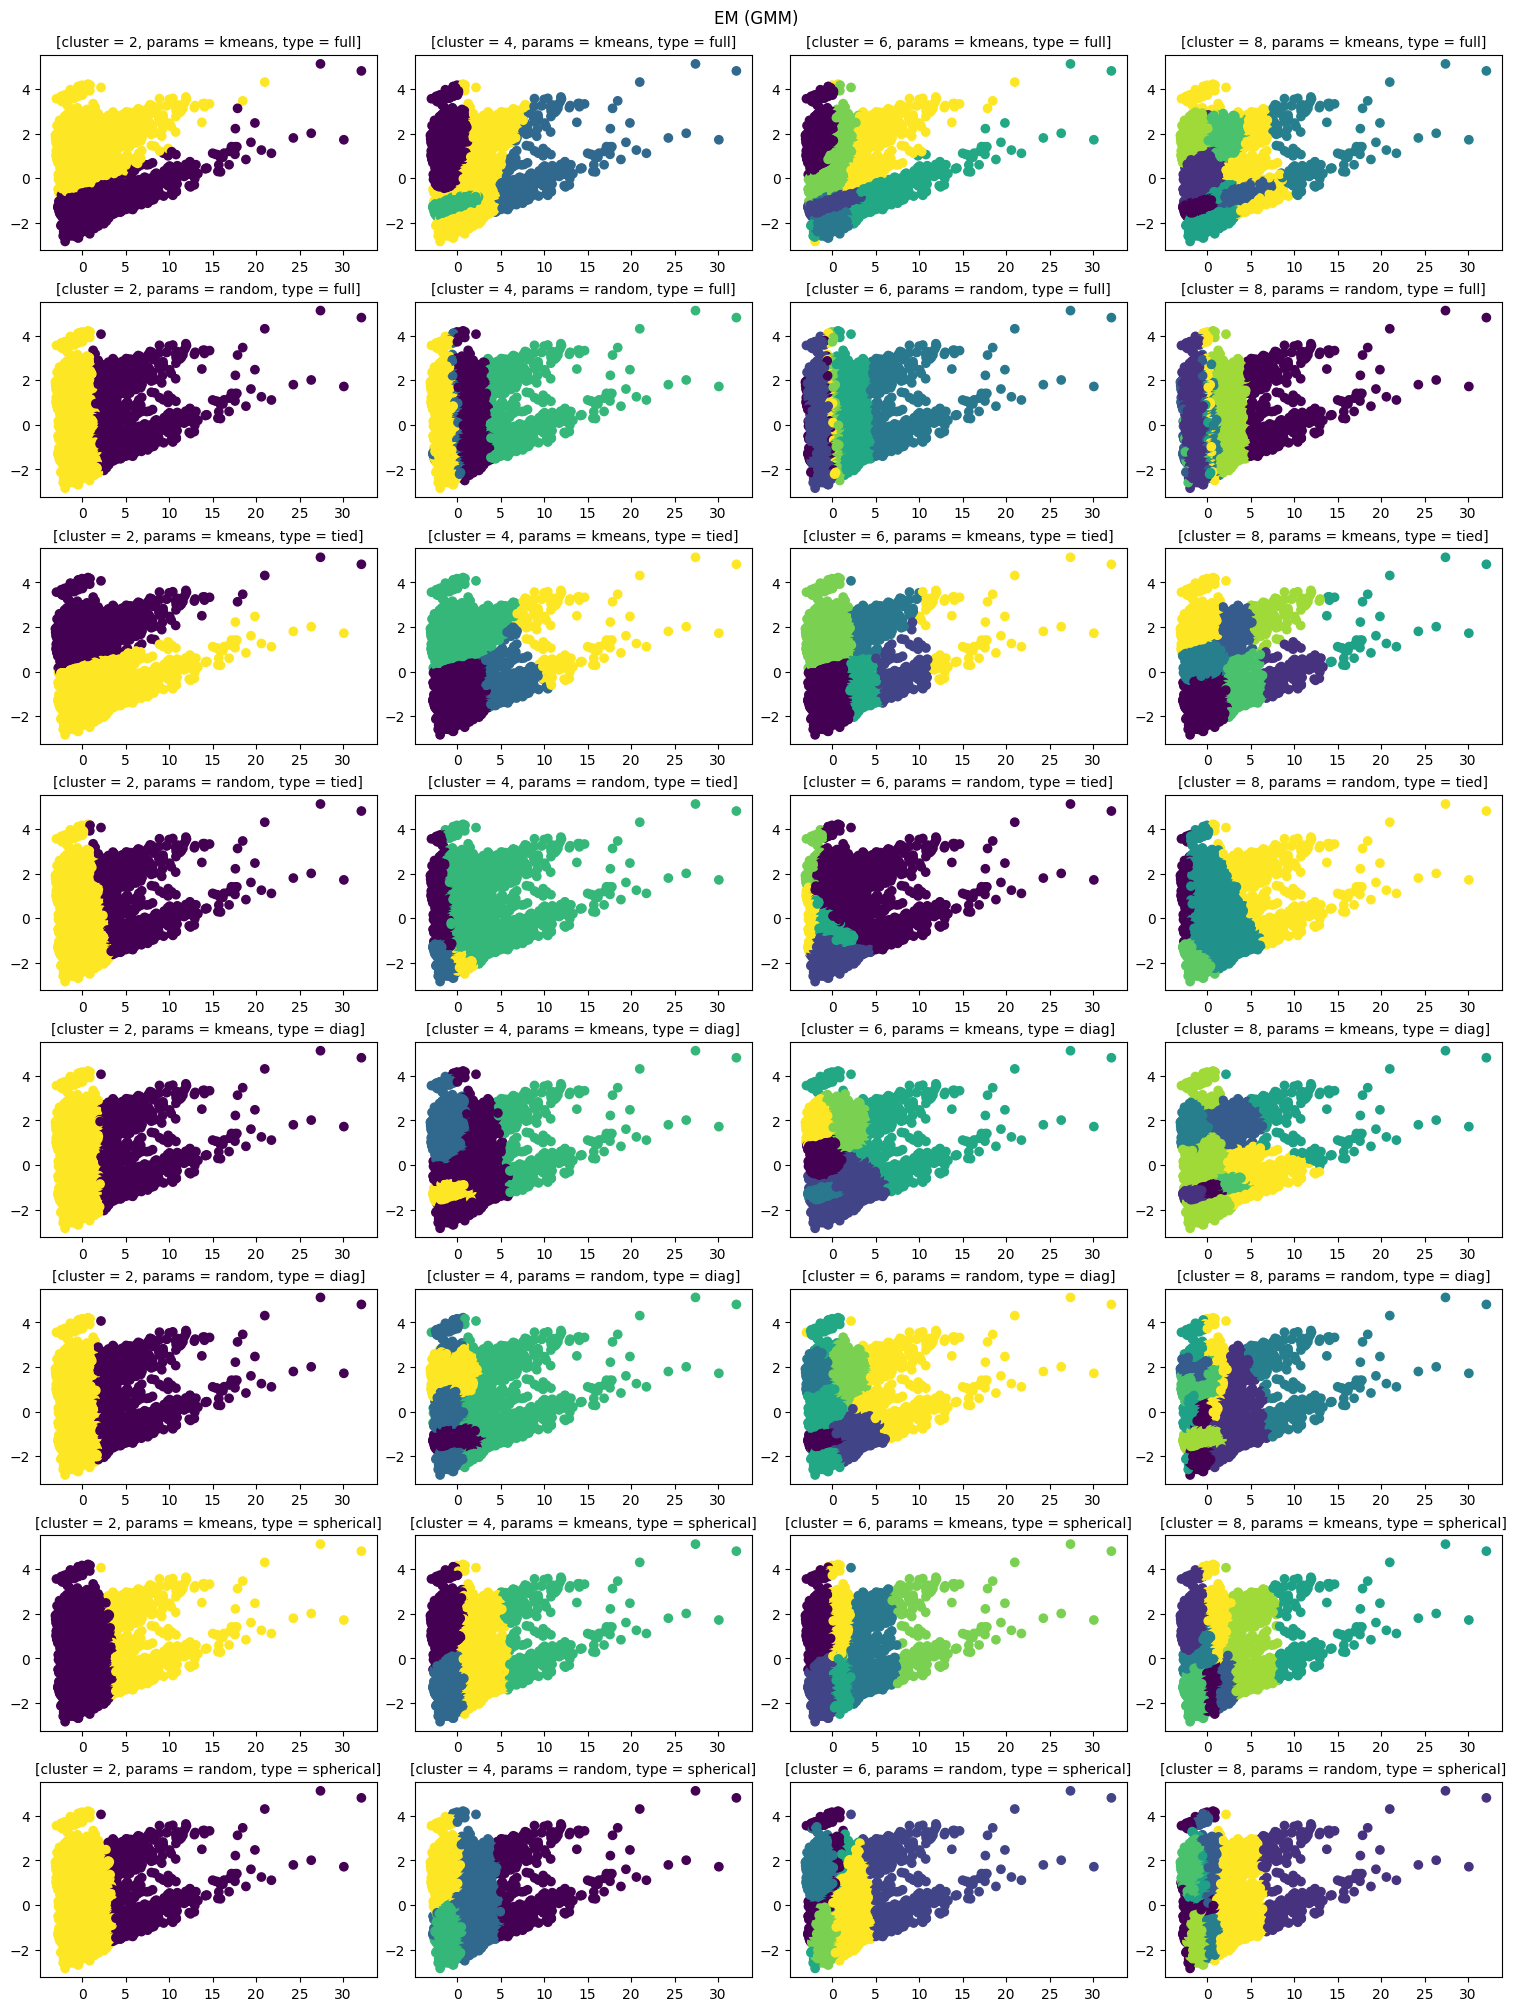

In [31]:
data = model_gaussian(x)
data.show()

CLARANS Clustering running time:  24.953125 sec


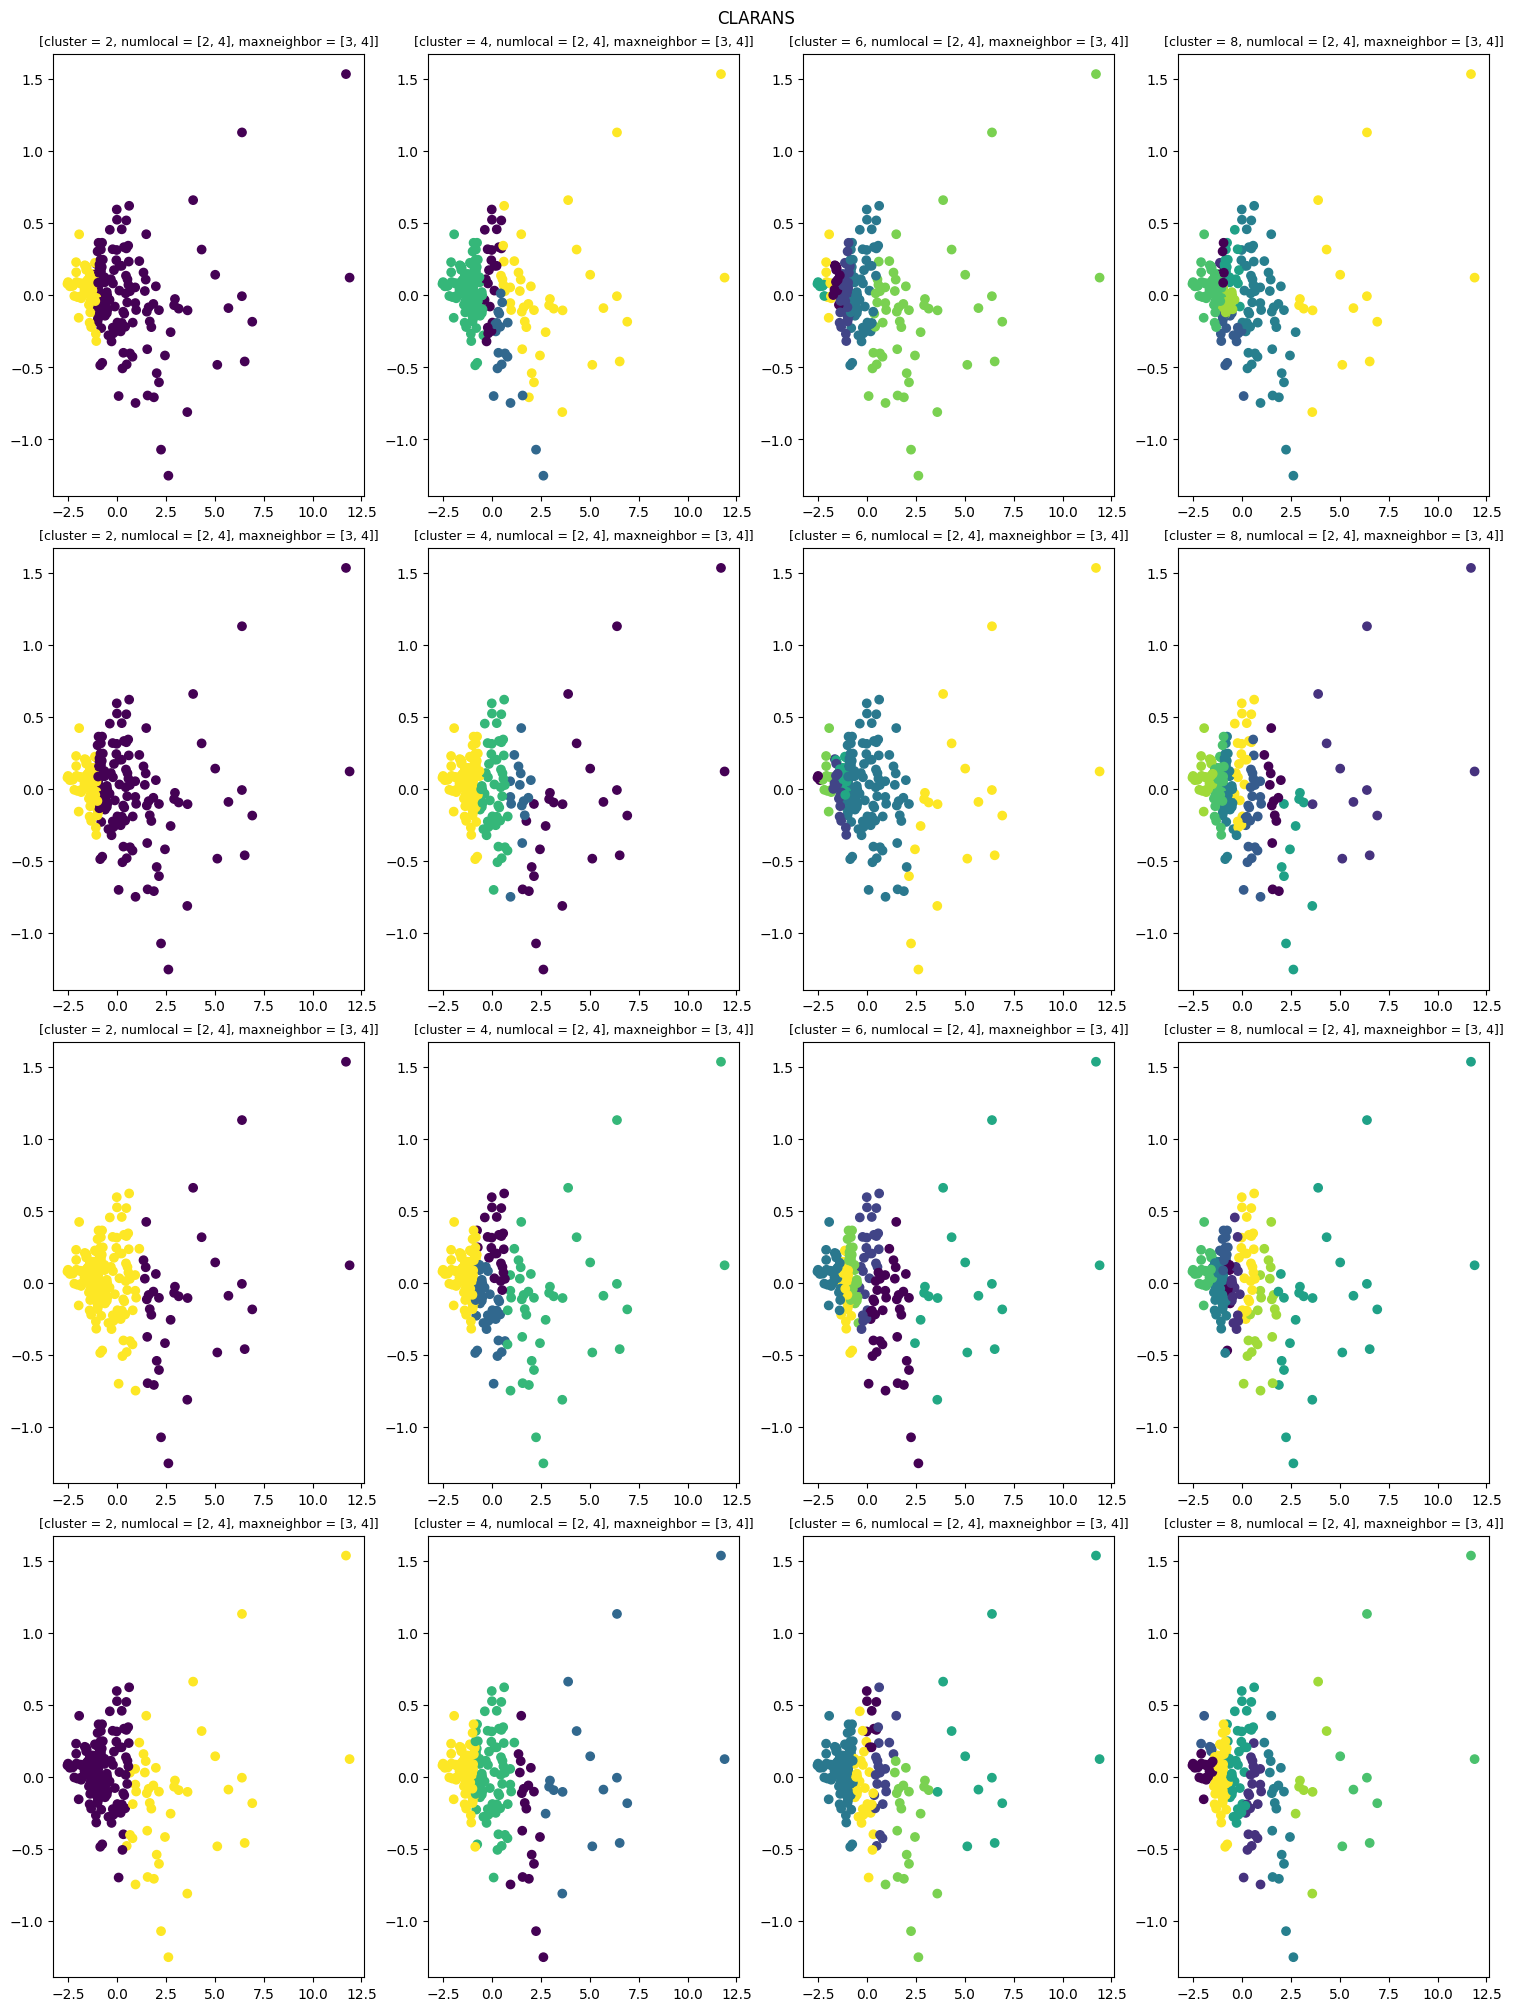

In [34]:
column = ['total_rooms', 'total_bedrooms', 'population', 'households']
a = x.loc[:, column]
a = a.sample(n=int(a.shape[0] * 0.01))

data = model_clarans(a)
data.show()